[nltk_data] Downloading package punkt to /Users/anniegrts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use mps:0


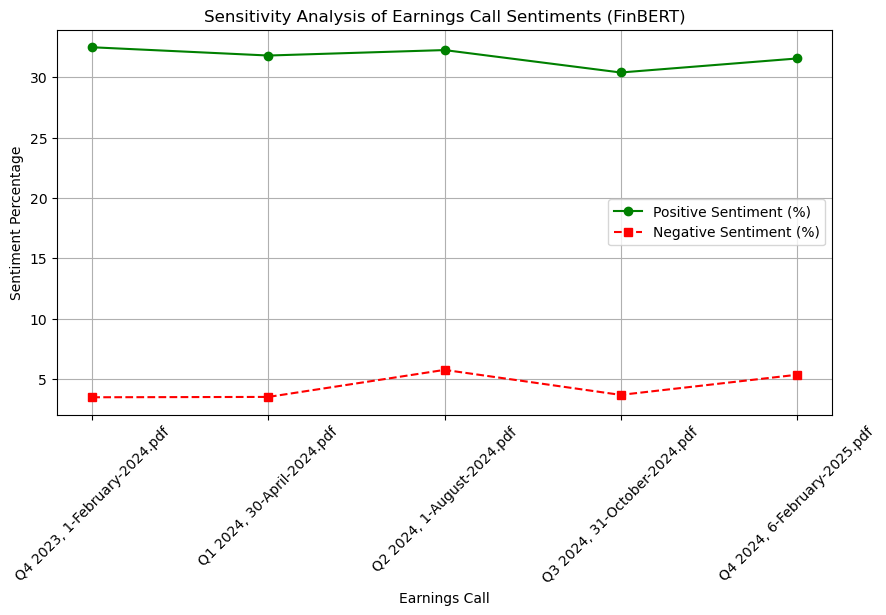

                  Earnings Call  Positive  Neutral  Negative  Total Sentences  \
0  Q4 2023, 1-February-2024.pdf       140      276        15              431   
1    Q1 2024, 30-April-2024.pdf       145      295        16              456   
2    Q2 2024, 1-August-2024.pdf       129      248        23              400   
3  Q3 2024, 31-October-2024.pdf       124      269        15              408   
4  Q4 2024, 6-February-2025.pdf       124      248        21              393   

   Positive %  Neutral %  Negative %  
0   32.482599  64.037123    3.480278  
1   31.798246  64.692982    3.508772  
2   32.250000  62.000000    5.750000  
3   30.392157  65.931373    3.676471  
4   31.552163  63.104326    5.343511  


In [14]:
import os
import PyPDF2
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline

# Download NLTK tokenizer (if not already installed)
nltk.download("punkt")

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

# Folder containing earnings call PDFs
folder_path = "Earning calls transcripts"

# Define the desired order of filenames
desired_order = [
    "Q4 2023, 1-February-2024.pdf",
    "Q1 2024, 30-April-2024.pdf",
    "Q2 2024, 1-August-2024.pdf",
    "Q3 2024, 31-October-2024.pdf",
    "Q4 2024, 6-February-2025.pdf"
]

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# Function to process sentences safely (truncate if >512 tokens)
def analyze_text_with_truncation(text):
    tokenized_text = tokenizer.encode(text, truncation=True, max_length=512, return_tensors="pt")
    sentiment = sentiment_pipeline(text[:512])[0]  # Only send 512 chars to avoid token mismatch
    return sentiment

# Process each PDF in the desired order
sentiment_results = []
for filename in desired_order:
    file_path = os.path.join(folder_path, filename)

    # Extract text from PDF
    transcript_text = extract_text_from_pdf(file_path)
    sentences = sent_tokenize(transcript_text)

    # Run sentiment analysis with truncation
    sentiments = [analyze_text_with_truncation(sentence) for sentence in sentences]

    # Count sentiment distribution
    sentiment_counts = {
        "positive": sum(1 for s in sentiments if s["label"] == "positive"),
        "neutral": sum(1 for s in sentiments if s["label"] == "neutral"),
        "negative": sum(1 for s in sentiments if s["label"] == "negative")
    }

    # Store results
    sentiment_results.append({
        "Earnings Call": filename,
        "Positive": sentiment_counts["positive"],
        "Neutral": sentiment_counts["neutral"],
        "Negative": sentiment_counts["negative"],
        "Total Sentences": len(sentiments),
        "Positive %": sentiment_counts["positive"] / len(sentiments) * 100,
        "Neutral %": sentiment_counts["neutral"] / len(sentiments) * 100,
        "Negative %": sentiment_counts["negative"] / len(sentiments) * 100
    })

# Convert results to DataFrame
df_results = pd.DataFrame(sentiment_results)

# Plot sensitivity analysis (Positive vs. Negative %)
plt.figure(figsize=(10, 5))
plt.plot(df_results["Earnings Call"], df_results["Positive %"], marker="o", linestyle="-", label="Positive Sentiment (%)", color="green")
plt.plot(df_results["Earnings Call"], df_results["Negative %"], marker="s", linestyle="--", label="Negative Sentiment (%)", color="red")
plt.xlabel("Earnings Call")
plt.ylabel("Sentiment Percentage")
plt.title("Sensitivity Analysis of Earnings Call Sentiments (FinBERT)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Print summarized sensitivity results
print(df_results)

[nltk_data] Downloading package punkt to /Users/anniegrts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📄 Processing: Q4 2023, 1-February-2024.pdf
📊 Section-level Sentiment:
  ➤ Prepared Remarks: Positive=3.48%, Negative=54.55%, Neutral=41.98%
  ➤ Q&A: Positive=2.44%, Negative=80.49%, Neutral=17.07%
  ➤ Conclusion: Positive=0.0%, Negative=100.0%, Neutral=0.0%
  ➤ Other: Positive=0.0%, Negative=100.0%, Neutral=0.0%

📄 Processing: Q1 2024, 30-April-2024.pdf
📊 Section-level Sentiment:
  ➤ Prepared Remarks: Positive=4.05%, Negative=45.95%, Neutral=50.0%
  ➤ Q&A: Positive=1.92%, Negative=65.38%, Neutral=32.69%
  ➤ Conclusion: Positive=0.0%, Negative=100.0%, Neutral=0.0%
  ➤ Other: Positive=0.0%, Negative=100.0%, Neutral=0.0%

📄 Processing: Q2 2024, 1-August-2024.pdf
📊 Section-level Sentiment:
  ➤ Prepared Remarks: Positive=6.34%, Negative=54.82%, Neutral=38.84%
  ➤ Q&A: Positive=9.52%, Negative=61.9%, Neutral=28.57%
  ➤ Conclusion: Positive=0.0%, Negative=100.0%, Neutral=0.0%
  ➤ Other: Positive=0.0%, Negative=100.0%, Neutral=0.0%

📄 Processing: Q3 2024, 31-October-2024.pdf
📊 Section-level S

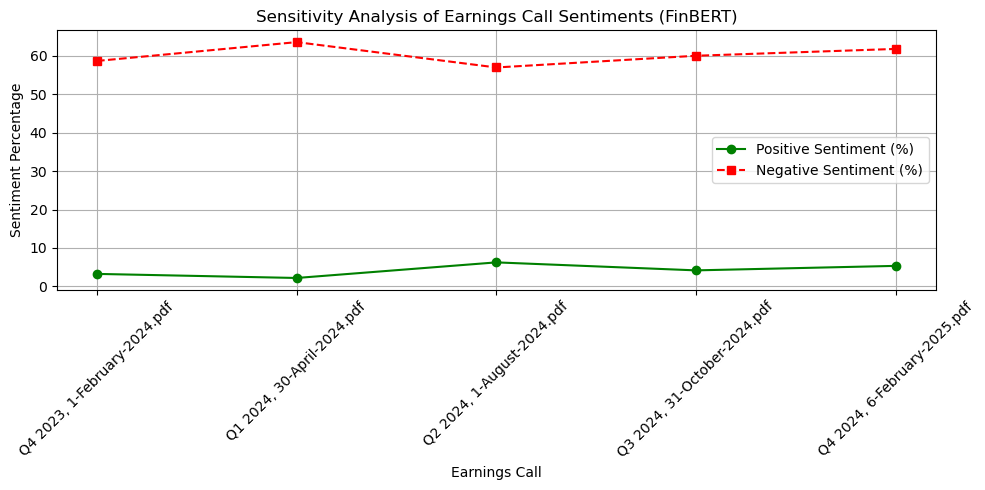

In [5]:
import os
import glob
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import sent_tokenize
import nltk

# Setup
nltk.download('punkt')

# Load FinBERT model and tokenizer
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
labels = ['negative', 'neutral', 'positive']

# Folder containing PDF earnings calls
FOLDER_PATH = "Earning calls transcripts"

# Define the desired order of filenames
desired_order = [
    "Q4 2023, 1-February-2024.pdf",
    "Q1 2024, 30-April-2024.pdf",
    "Q2 2024, 1-August-2024.pdf",
    "Q3 2024, 31-October-2024.pdf",
    "Q4 2024, 6-February-2025.pdf"
]

# Extract all text from PDF
def extract_text_from_pdf(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        return " ".join([page.extract_text() or "" for page in reader.pages])
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return ""

# Split transcript into sections
def split_into_sections(text):
    section_patterns = {
        'Prepared Remarks': r"(prepared remarks|opening remarks|introduction)",
        'Q&A': r"(q[\s&]*a|questions and answers|analyst questions)",
        'Conclusion': r"(conclusion|closing remarks|summary)"
    }

    sections = {'Prepared Remarks': '', 'Q&A': '', 'Conclusion': '', 'Other': ''}
    current_section = 'Other'
    for line in text.split('\n'):
        lower_line = line.lower().strip()
        matched = False
        for section, pattern in section_patterns.items():
            if re.search(pattern, lower_line):
                current_section = section
                matched = True
                break
        sections[current_section] += line + '\n'
    return sections

# Run FinBERT sentiment analysis on text
def analyze_sentiment_finbert(text):
    sentences = sent_tokenize(text)
    sentiments = {"positive": 0, "negative": 0, "neutral": 0}
    total = 0

    for sentence in sentences:
        if len(sentence.strip()) == 0:
            continue

        # Tokenize the sentence
        inputs = finbert_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)

        # If the sentence is too long, split it into chunks of 512 tokens
        if inputs['input_ids'].size(1) > 512:
            chunks = [inputs['input_ids'][:, i:i+512] for i in range(0, inputs['input_ids'].size(1), 512)]
            attention_masks = [inputs['attention_mask'][:, i:i+512] for i in range(0, inputs['attention_mask'].size(1), 512)]
        else:
            chunks = [inputs['input_ids']]
            attention_masks = [inputs['attention_mask']]

        for chunk, attention_mask in zip(chunks, attention_masks):
            with torch.no_grad():
                outputs = finbert_model(input_ids=chunk, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            label = labels[probs.argmax()]
            sentiments[label] += 1
            total += 1

    if total == 0:
        return 0, 0, 0

    return round(sentiments["positive"] / total * 100, 2), round(sentiments["negative"] / total * 100, 2), round(sentiments["neutral"] / total * 100, 2)

# Main loop
overall_results = []

for pdf_file in desired_order:
    file_path = os.path.join(FOLDER_PATH, pdf_file)
    file_name = os.path.basename(file_path)
    print(f"\n📄 Processing: {file_name}")
    text = extract_text_from_pdf(file_path)
    if not text.strip():
        print("No text found.")
        continue

    sections = split_into_sections(text)

    print("📊 Section-level Sentiment:")
    for sec_name, sec_text in sections.items():
        pos, neg, neu = analyze_sentiment_finbert(sec_text)
        print(f"  ➤ {sec_name}: Positive={pos}%, Negative={neg}%, Neutral={neu}%")

    # Overall sentiment from all sections combined
    full_text = "\n".join(sections.values())
    pos_pct, neg_pct, neu_pct = analyze_sentiment_finbert(full_text)

    overall_results.append({
        "Earnings Call": file_name,
        "Positive %": pos_pct,
        "Negative %": neg_pct,
        "Neutral %": neu_pct
    })

# Plot sentiment across earnings calls
if overall_results:
    df_results = pd.DataFrame(overall_results)
    plt.figure(figsize=(10, 5))
    plt.plot(df_results["Earnings Call"], df_results["Positive %"], marker="o", linestyle="-", label="Positive Sentiment (%)", color="green")
    plt.plot(df_results["Earnings Call"], df_results["Negative %"], marker="s", linestyle="--", label="Negative Sentiment (%)", color="red")
    plt.xlabel("Earnings Call")
    plt.ylabel("Sentiment Percentage")
    plt.title("Sensitivity Analysis of Earnings Call Sentiments (FinBERT)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package punkt to /Users/anniegrts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



📄 Processing: Q4 2023, 1-February-2024.pdf

📄 Processing: Q1 2024, 30-April-2024.pdf

📄 Processing: Q2 2024, 1-August-2024.pdf

📄 Processing: Q3 2024, 31-October-2024.pdf

📄 Processing: Q4 2024, 6-February-2025.pdf


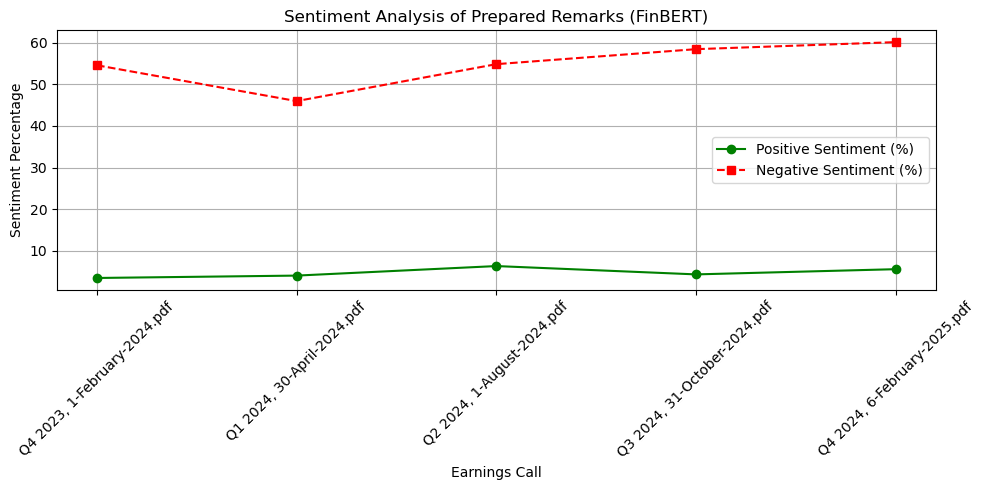

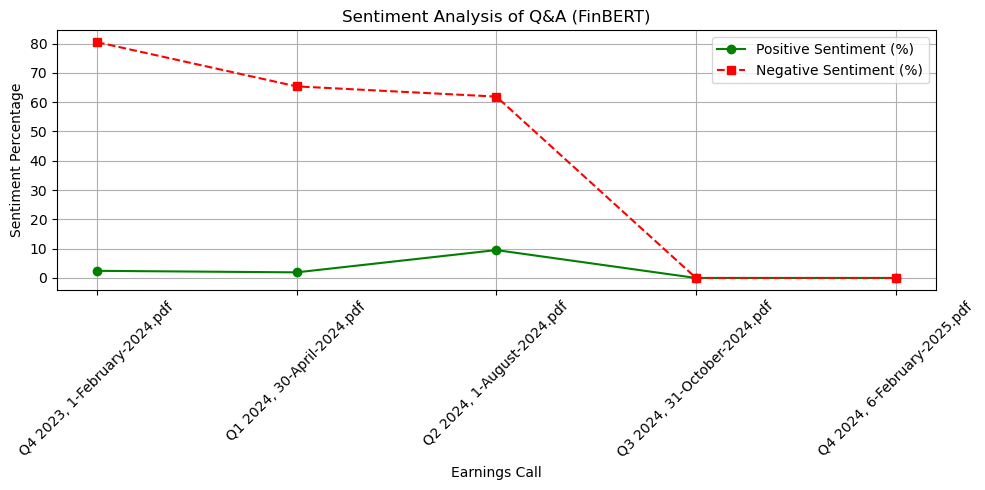

In [6]:
import os
import glob
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.tokenize import sent_tokenize
import nltk

# Setup
nltk.download('punkt')

# Load FinBERT model and tokenizer
finbert_model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
finbert_tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
labels = ['negative', 'neutral', 'positive']

# Folder containing PDF earnings calls
FOLDER_PATH = "Earning calls transcripts"

# Define the desired order of filenames
desired_order = [
    "Q4 2023, 1-February-2024.pdf",
    "Q1 2024, 30-April-2024.pdf",
    "Q2 2024, 1-August-2024.pdf",
    "Q3 2024, 31-October-2024.pdf",
    "Q4 2024, 6-February-2025.pdf"
]

# Extract all text from PDF
def extract_text_from_pdf(pdf_path):
    try:
        reader = PdfReader(pdf_path)
        return " ".join([page.extract_text() or "" for page in reader.pages])
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
        return ""

# Split transcript into sections
def split_into_sections(text):
    section_patterns = {
        'Prepared Remarks': r"(prepared remarks|opening remarks|introduction)",
        'Q&A': r"(q[\s&]*a|questions and answers|analyst questions)",
        'Conclusion': r"(conclusion|closing remarks|summary)"
    }

    sections = {'Prepared Remarks': '', 'Q&A': '', 'Conclusion': '', 'Other': ''}
    current_section = 'Other'
    for line in text.split('\n'):
        lower_line = line.lower().strip()
        matched = False
        for section, pattern in section_patterns.items():
            if re.search(pattern, lower_line):
                current_section = section
                matched = True
                break
        sections[current_section] += line + '\n'
    return sections

# Run FinBERT sentiment analysis on text
def analyze_sentiment_finbert(text):
    sentences = sent_tokenize(text)
    sentiments = {"positive": 0, "negative": 0, "neutral": 0}
    total = 0

    for sentence in sentences:
        if len(sentence.strip()) == 0:
            continue

        # Tokenize the sentence
        inputs = finbert_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)

        # If the sentence is too long, split it into chunks of 512 tokens
        if inputs['input_ids'].size(1) > 512:
            chunks = [inputs['input_ids'][:, i:i+512] for i in range(0, inputs['input_ids'].size(1), 512)]
            attention_masks = [inputs['attention_mask'][:, i:i+512] for i in range(0, inputs['attention_mask'].size(1), 512)]
        else:
            chunks = [inputs['input_ids']]
            attention_masks = [inputs['attention_mask']]

        for chunk, attention_mask in zip(chunks, attention_masks):
            with torch.no_grad():
                outputs = finbert_model(input_ids=chunk, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            label = labels[probs.argmax()]
            sentiments[label] += 1
            total += 1

    if total == 0:
        return 0, 0, 0

    return round(sentiments["positive"] / total * 100, 2), round(sentiments["negative"] / total * 100, 2), round(sentiments["neutral"] / total * 100, 2)

# Main loop
section_results = {'Prepared Remarks': [], 'Q&A': []}

for pdf_file in desired_order:
    file_path = os.path.join(FOLDER_PATH, pdf_file)
    file_name = os.path.basename(file_path)
    print(f"\n📄 Processing: {file_name}")
    text = extract_text_from_pdf(file_path)
    if not text.strip():
        print("No text found.")
        continue

    sections = split_into_sections(text)

    for sec_name in ['Prepared Remarks', 'Q&A']:
        sec_text = sections[sec_name]
        pos, neg, neu = analyze_sentiment_finbert(sec_text)
        section_results[sec_name].append({
            "Earnings Call": file_name,
            "Positive %": pos,
            "Negative %": neg,
            "Neutral %": neu
        })

# Plot sentiment for Prepared Remarks and Q&A sections
for section, results in section_results.items():
    if results:
        df_results = pd.DataFrame(results)
        plt.figure(figsize=(10, 5))
        plt.plot(df_results["Earnings Call"], df_results["Positive %"], marker="o", linestyle="-", label="Positive Sentiment (%)", color="green")
        plt.plot(df_results["Earnings Call"], df_results["Negative %"], marker="s", linestyle="--", label="Negative Sentiment (%)", color="red")
        plt.xlabel("Earnings Call")
        plt.ylabel("Sentiment Percentage")
        plt.title(f"Sentiment Analysis of {section} (FinBERT)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
data = {
    'quarter': ['Q4 2023', 'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024'],
    'date': ['2024-02-01', '2024-04-30', '2024-08-01', '2024-10-31', '2025-02-06'],
    'positive_sentiment': [32.48, 31.80, 32.25, 30.39, 31.55],
    'negative_sentiment': [3.48, 3.51, 5.75, 3.68, 5.34]
}
calls_df = pd.DataFrame(data)
calls_df['date'] = pd.to_datetime(calls_df['date'])
calls_df['sentiment_ratio'] = calls_df['positive_sentiment'] / calls_df['negative_sentiment']

# Extraction of Amazon's stock prices (Open & Close)
amzn = yf.download("AMZN", start="2024-01-01", end="2025-03-01")
prices = amzn['Close']

# Étape 3 : Fonction pour calculer les rendements
def get_return(start_date, days_forward):
    try:
        pre_price = prices[prices.index >= start_date].iloc[0]
        future_price = prices[prices.index >= start_date + pd.Timedelta(days=days_forward)].iloc[0]
        return (future_price - pre_price) / pre_price * 100
    except:
        return np.nan

# Returns calculation
calls_df['1d_return'] = calls_df['date'].apply(lambda d: get_return(d, 1))
calls_df['3d_return'] = calls_df['date'].apply(lambda d: get_return(d, 3))
calls_df['5d_return'] = calls_df['date'].apply(lambda d: get_return(d, 5))
calls_df['1w_return'] = calls_df['date'].apply(lambda d: get_return(d, 7))

display(calls_df[['quarter', 'date', 'positive_sentiment', 'negative_sentiment',
                  'sentiment_ratio', '1d_return', '3d_return', '5d_return', '1w_return']])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,quarter,date,positive_sentiment,negative_sentiment,sentiment_ratio,1d_return,3d_return,5d_return,1w_return
0,Q4 2023,2024-02-01,32.48,3.48,9.333333,7.866649,6.924911,6.196632,6.629833
1,Q1 2024,2024-04-30,31.80,3.51,9.059829,2.285714,6.405718,7.828570,7.862854
2,Q2 2024,2024-08-01,32.25,5.75,5.608696,-8.784708,-12.522411,-12.028040,-9.925574
3,Q3 2024,2024-10-31,30.39,3.68,8.258152,6.185622,5.032192,7.027901,12.687774
4,Q4 2024,2025-02-06,31.55,5.34,5.908240,-4.053095,-2.382449,-2.541560,-3.542271
